In [40]:
#Importing the relevant modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import icd
from prince import MCA
import prince
from prince import mca
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import seaborn as sns
import seaborn
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.cluster import AgglomerativeClustering
from itertools import combinations

Loading in the Charlson comorbidity data to perform Agglomerative clustering, which is a a type of hierarchical clustering that builds clusters incrementally. Each data point starts as its own individual cluster. So if there are n data points, there will be n clusters initially. The algorithm then repeatedly merges the closest or most similar clusters. At each step, the two clusters with the smallest distance (or highest similarity) between them are merged into a single cluster. This process continues until all data points are in one single cluster, or until a stopping criterion (like a desired number of clusters) is met.

In [41]:
cluster_df= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/charl_subset.csv", sep= ',', header=0)

In [42]:
cluster_df= cluster_df.set_index('eid')

In [43]:
# Initializing a StandardScaler object, which will be used to standardize the features by removing the mean and scaling to unit variance.
# Fit the StandardScaler to the data in cluster_df and transform it. 
# This will standardize the data such that each feature will have a mean of 0 and a standard deviation of 1.
scaler= StandardScaler()
scaled_data= scaler.fit_transform(cluster_df)

Initializing an AgglomerativeClustering object with the number of clusters set to 4 and the linkage criterion set to 'ward'. The 'ward' linkage minimizes the variance of the clusters being merged, which generally leads to clusters of similar size. The number of clusters is set at 4.

In [44]:
ward_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
ward_labels = ward_clustering.fit_predict(scaled_data)

In [45]:
#Adding a column in the cluster_df which states which cluster each patient belongs to
cluster_df['cluster'] = ward_labels

In [46]:
#Performing mca on cluster_df which contains charlson comorbidities as features.
mca= prince.MCA(n_components=4)
mca= mca.fit(cluster_df.iloc[:, :-1])

Creating a scatter plot between principle components 2 and 3 of the charlson comorbidity multiple correspondence analysis as distinct separations were observed between the datapoints. The clustering was performed to check the meaningfulness of these seperations.

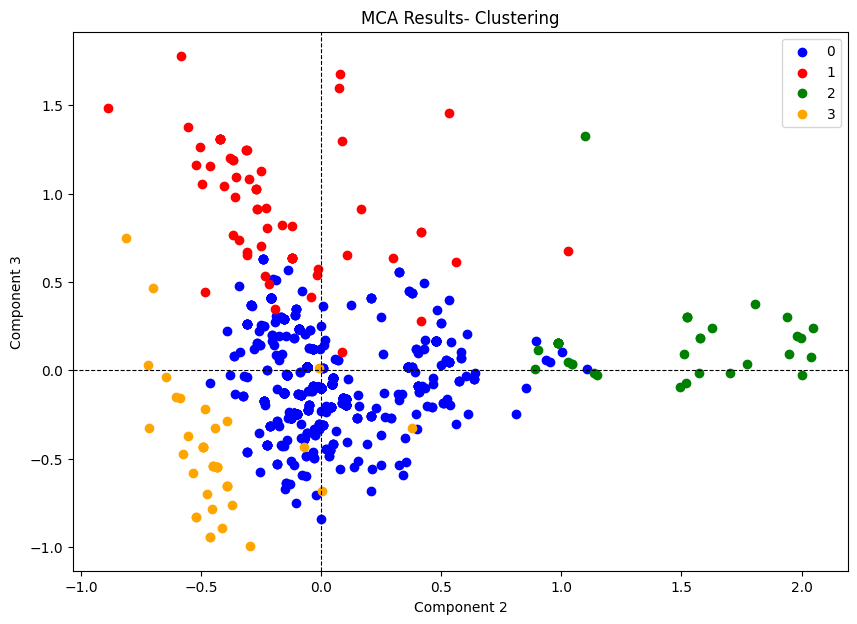

In [47]:
#Creating a dictionary to assign one colour to each cluster
color_dict = {0: 'blue', 1: 'red', 2:'green', 3: 'orange'}
plt.figure(figsize=(10, 7))

#Extracting the coordinates for each data point
coordinates = mca.row_coordinates(cluster_df.iloc[:, :-1])

#colouring the data points by the cluster they belong to using the colour_dict
for cluster in color_dict:
    indices = cluster_df.index[cluster_df['cluster'] == cluster]
    cluster_coordinates = coordinates.loc[indices]
    plt.scatter(cluster_coordinates.iloc[:, 1], cluster_coordinates.iloc[:, 2], c=color_dict[cluster], label=cluster)
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.title('MCA Results- Clustering')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical line at x=0


plt.legend()

plt.show()

Loading in the charlson master table consisting information regarding sex, deprivation score and category and type of leukaemia along with charlson comorbidities.

In [48]:
charl_master_subset= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/charl_master_subset.csv", sep=',', header=0, low_memory= 'False')

In [49]:
age_df= pd.read_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/age_df.csv', sep=',', header=0)

In [50]:
age_df.set_index('Unnamed: 0', inplace=True)
age_df.index.name = 'eid'

In [51]:
columns_to_map = charl_master_subset.iloc[:, 18:22].columns
for column in columns_to_map:
    charl_master_subset[column] = charl_master_subset[column].map({True: 1, False: 0})

In [52]:
#Adding the cluster information to the master table
charl_master_subset['cluster']= ward_labels

Loading in the data containing the information regarding the leukaemia subtype (AML, CML, ALL, CLL) for each patient.

In [53]:
leukemia_types_df= pd.read_csv("C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/leukemia_types_df_subset.csv", sep=',', header=0, low_memory= 'False')

In [54]:
charl_master_subset= charl_master_subset.merge(leukemia_types_df[['ML', 'LL', 'Acute', 'Chronic']], left_index= True, right_index= True)

In [55]:
columns_to_analyze = charl_master_subset.columns.difference(['index_of_multiple_deprivation_england_f26410_0_0', 'age_at_death_f40007_0_0', 'cluster', 'eid', 'PC1', 'PC2', 'PC3', 'PC4'],)

Performing a multi-variate chi-square test for each of the categorical variables, including charlson comorbidities, sex and category to examine which features are significantly segregating the clusters. 

In [56]:
results = []
for column in columns_to_analyze:
    ct = pd.crosstab(index=charl_master_subset[column], columns=charl_master_subset['cluster'], margins=False)
    chi2, p, dof, expected = chi2_contingency(ct)
    result_dict = {
        'Condition': column,
        'Chi-squared test statistic': chi2,
        'p-value': p,
        'Degrees of freedom': dof,
        }
    results.append(result_dict)

#Converting the results into a dataframe 
results_df = pd.DataFrame(results)

#Sorting the results by their p-value
results_df.sort_values('p-value')


,Condition,Chi-squared test statistic,p-value,Degrees of freedom
20,moderate_or_sever_liver_disease,1755.961515,0.000000e+00,3
16,diabetes_w_complications,1719.707666,0.000000e+00,3
22,paraplegia_and_hemiplegia,909.354827,8.277360e-197,3
15,dementia,899.835909,9.607682e-195,3
17,diabetes_wo_complications,236.511641,5.405560e-51,3
19,mild_liver_disease,133.154946,1.130096e-28,3
11,cerebrovascular_disease,131.348677,2.769616e-28,3
25,renal_disease,42.760023,2.767325e-09,3
23,peptic_ulcer_disease,39.460616,1.386351e-08,3
13,congestive_heart_failure,22.907870,4.220857e-05,3


In [57]:
#Performing MCA again on Charlson comorbidities but this time using the master dataframe
comor_columns= charl_master_subset.columns[1:18]
mca= prince.MCA(n_components=4)
mca= mca.fit(charl_master_subset[comor_columns])

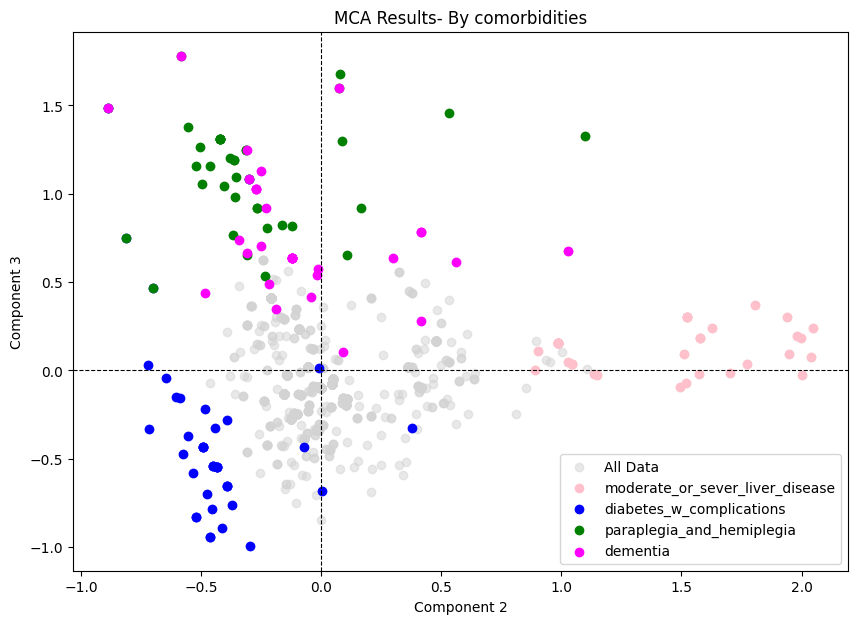

In [58]:
# Defining color dictionary for specific diseases
color_dict = {'moderate_or_sever_liver_disease': 'pink', 'diabetes_w_complications': 'blue', 'paraplegia_and_hemiplegia': 'green', 'dementia': 'magenta'}

# Creating a figure for the plot
plt.figure(figsize=(10, 7))
# Get row coordinates from the MCA result
coordinates = mca.row_coordinates(charl_master_subset[comor_columns])

# Plotting all points in a base color (e.g., light gray)
plt.scatter(coordinates.iloc[:, 1], coordinates.iloc[:, 2], c='lightgray', label='All Data', alpha=0.5)

# Overlaying colored points for each specific disease category
for category, color in color_dict.items():
    indices = charl_master_subset.index[charl_master_subset[category] == 1]
    category_coordinates = coordinates.loc[indices]
    plt.scatter(category_coordinates.iloc[:, 1], category_coordinates.iloc[:, 2], c=color, label=category)

# Labelling axes and title
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.title('MCA Results- By comorbidities')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical line at x=0


# Adding legend
plt.legend()

# Showing the plot
plt.show()

Creating a subset of the master table only containing patients with more than or equal to 4 comorbidities to extract highly comorbid population.

In [59]:
# Listing of columns that represent comorbidities
comorbidity_columns = ['myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'cancer', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv'
    # Add other comorbidity columns as necessary
]

# Creating a new column that counts the number of comorbidities for each patient
charl_master_subset['comorbidity_count'] = charl_master_subset[comorbidity_columns].sum(axis=1)

# Subsetting the table based on the number of comorbidities (4)
subset = charl_master_subset[charl_master_subset['comorbidity_count'] >= 4]


In [60]:
subset

,eid,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,PC2,PC3,PC4,category,cluster,ML,LL,Acute,Chronic,comorbidity_count
1,1002951,1,0,0,1,0,1,0,0,0,...,-0.324114,-0.145284,-0.167703,NaN,0,False,True,False,True,5
8,1028806,1,1,0,0,0,1,0,0,0,...,-0.064224,-0.599393,-0.415063,high,0,True,False,True,False,5
17,1061942,0,0,1,0,0,0,0,1,0,...,0.320073,-0.131601,0.157994,low,0,True,False,True,False,4
19,1070339,0,1,0,0,0,0,0,1,1,...,1.105073,0.007732,-0.257437,low,0,False,True,False,True,5
21,1073965,1,0,0,1,0,1,1,0,0,...,-0.258689,0.221927,-0.748475,high,0,True,False,True,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,5865667,1,1,1,0,0,1,0,0,0,...,-0.105565,-0.748410,-0.482321,high,0,False,True,False,True,7
1750,5867653,0,0,0,0,0,1,0,0,1,...,1.577807,0.184755,0.286628,high,2,True,False,True,False,4
1764,5914528,1,0,0,1,0,1,0,0,0,...,-0.224891,0.002923,-0.393325,high,0,False,True,False,True,4
1776,5954578,0,1,1,0,1,1,0,0,0,...,-0.040508,0.415035,-0.737764,high,1,False,True,False,True,5


further subsetting the master table table with patients from the high and low deprivation populations (first 25th and last 75th percentile respectively based on the index of multiple deprivation score).

In [61]:
charl_master_high = charl_master_subset[charl_master_subset['category'] == 'high']

In [62]:
charl_master_low = charl_master_subset[charl_master_subset['category'] == 'low']

Extracting the most commonly co-occurring comorbidities in each leukaemia sub-type.

In [63]:
# Defining the categories
categories = ['ALL', 'AML', 'CLL', 'CML']

# Defining the comorbidity columns
comorbidity_columns = ['myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv']

# Function to count co-occurrences of comorbidities
def count_cooccurrences(data, comorbidities):
    cooccurrence_counts = {}
    for comb in combinations(comorbidities, 2):
        cooccurrence_counts[comb] = ((data[comb[0]] == 1) & (data[comb[1]] == 1)).sum()
    return cooccurrence_counts

# Dictionary to store the results
cooccurrence_results = {category: {} for category in categories}

# Calculating the co-occurrences for each category
for category in categories:
    category_data = charl_master_subset[charl_master_subset[category] == True]
    cooccurrence_counts = count_cooccurrences(category_data, comorbidity_columns)
    cooccurrence_results[category] = cooccurrence_counts

# Identifying the most common pairs for each category
most_common_cooccurrences = {category: max(cooccurrence_results[category], key=cooccurrence_results[category].get) for category in categories}

# Printing the results
for category, cooccurrence in most_common_cooccurrences.items():
    print(f"The most commonly co-occurring comorbidities in {category} are: {cooccurrence} with {cooccurrence_results[category][cooccurrence]} occurrences")


The most commonly co-occurring comorbidities in ALL are: ('chronic_pulmonary_disease', 'diabetes_wo_complications') with 47 occurrences
The most commonly co-occurring comorbidities in AML are: ('congestive_heart_failure', 'chronic_pulmonary_disease') with 30 occurrences
The most commonly co-occurring comorbidities in CLL are: ('diabetes_wo_complications', 'renal_disease') with 12 occurrences
The most commonly co-occurring comorbidities in CML are: ('congestive_heart_failure', 'cerebrovascular_disease') with 4 occurrences


Extracting the most commonly co-occuring comorbidites across all leukaemia sub-types in low and high deprivation categories.

In [64]:

# Defining the categories
categories = ['ALL', 'AML', 'CLL', 'CML']

# Defining the comorbidity columns
comorbidity_columns = ['myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv']

#Function to count the number of co-occurences by utilising the combinations class from the itertools built-in python module
def count_cooccurrences(data, comorbidities):
    """
    Counting co-occurrences of comorbidities in the given data.
    
    Parameters:
    data (DataFrame): The dataframe containing the comorbidity data.
    comorbidities (list): List of comorbidity columns to check for co-occurrences.
    
    Returns:
    dict: A dictionary with pairs of comorbidities as keys and their co-occurrence counts as values.
    """
    cooccurrence_counts = {}
    for comb in combinations(comorbidities, 2):
        cooccurrence_counts[comb] = ((data[comb[0]] == 1) & (data[comb[1]] == 1)).sum()
    return cooccurrence_counts

#Function to extract the most comoonly co-occuring comorbidities
def most_common_cooccurrences(charl_master, categories, comorbidity_columns):
    """
    Identifying the most common co-occurring comorbidities for each category.
    
    Parameters:
    charl_master (DataFrame): The dataframe containing the main data.
    categories (list): List of categories to analyze.
    comorbidity_columns (list): List of comorbidity columns to check for co-occurrences.
    
    Returns:
    dict: A dictionary with the most common co-occurring comorbidities for each category.
    """
    cooccurrence_results = {category: {} for category in categories}

    # Calculating the co-occurrences for each category
    for category in categories:
        category_data = charl_master[charl_master[category] == True]
        cooccurrence_counts = count_cooccurrences(category_data, comorbidity_columns)
        cooccurrence_results[category] = cooccurrence_counts

    # Identifying the most common pairs for each category
    most_common_cooccurrences = {category: max(cooccurrence_results[category], key=cooccurrence_results[category].get) for category in categories}

    # Printing the results
    for category, cooccurrence in most_common_cooccurrences.items():
        print(f"The most commonly co-occurring comorbidities in {category} are: {cooccurrence} with {cooccurrence_results[category][cooccurrence]} occurrences")
    
    return most_common_cooccurrences

# Example usage
# Assuming charl_master is your DataFrame containing the relevant data
# most_common_cooccurrences(charl_master, categories, comorbidity_columns)


Applying the most_common_cooccurrences function.

In [65]:
most_common_cooccurrences(charl_master_low, categories, comorbidity_columns)

The most commonly co-occurring comorbidities in ALL are: ('chronic_pulmonary_disease', 'diabetes_wo_complications') with 12 occurrences
The most commonly co-occurring comorbidities in AML are: ('congestive_heart_failure', 'renal_disease') with 9 occurrences
The most commonly co-occurring comorbidities in CLL are: ('chronic_pulmonary_disease', 'diabetes_wo_complications') with 3 occurrences
The most commonly co-occurring comorbidities in CML are: ('diabetes_wo_complications', 'paraplegia_and_hemiplegia') with 2 occurrences


{'ALL': ('chronic_pulmonary_disease', 'diabetes_wo_complications'),
 'AML': ('congestive_heart_failure', 'renal_disease'),
 'CLL': ('chronic_pulmonary_disease', 'diabetes_wo_complications'),
 'CML': ('diabetes_wo_complications', 'paraplegia_and_hemiplegia')}

In [66]:
most_common_cooccurrences(charl_master_high, categories, comorbidity_columns)

The most commonly co-occurring comorbidities in ALL are: ('chronic_pulmonary_disease', 'diabetes_wo_complications') with 32 occurrences
The most commonly co-occurring comorbidities in AML are: ('congestive_heart_failure', 'chronic_pulmonary_disease') with 23 occurrences
The most commonly co-occurring comorbidities in CLL are: ('diabetes_wo_complications', 'renal_disease') with 10 occurrences
The most commonly co-occurring comorbidities in CML are: ('congestive_heart_failure', 'cerebrovascular_disease') with 3 occurrences


{'ALL': ('chronic_pulmonary_disease', 'diabetes_wo_complications'),
 'AML': ('congestive_heart_failure', 'chronic_pulmonary_disease'),
 'CLL': ('diabetes_wo_complications', 'renal_disease'),
 'CML': ('congestive_heart_failure', 'cerebrovascular_disease')}

In [67]:
charl_master_subset.columns

Index(['eid', 'myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'cancer', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv', 'AML', 'CML', 'ALL', 'CLL',
       'sex_f31_0_0', 'index_of_multiple_deprivation_england_f26410_0_0',
       'age_at_death_f40007_0_0', 'PC1', 'PC2', 'PC3', 'PC4', 'category',
       'cluster', 'ML', 'LL', 'Acute', 'Chronic', 'comorbidity_count'],
      dtype='object')

Creating a function to calculate the most commonly occurring comorbidities across all leukaemia sub-types in each deprivation category.

In [70]:
categories = ['ALL', 'AML', 'CLL', 'CML']

# Defining the comorbidity columns
comorbidity_columns = ['myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv']

# Function to count occurrences of comorbidities
def count_occurrences(data, comorbidities):
    occurrence_counts = {}
    for comorbidity in comorbidities:
        occurrence_counts[comorbidity] = (data[comorbidity] == 1).sum()
    return occurrence_counts

# Initializing an empty dictionary for occurrence results
occurrence_results = {}

# Populating the dictionary with categories as keys, each with an empty dictionary as the value
for category in categories:
    occurrence_results[category] = {}
    
#HIGH-CATEGORY   
# Calculating the occurrences for each category
for category in categories:
    category_data = charl_master_high[charl_master_high[category] == True]
    occurrence_counts = count_occurrences(category_data, comorbidity_columns)
    occurrence_results[category] = occurrence_counts

# Initializing an empty dictionary for the most common occurrences
most_common_occurrences = {}

# Iterating over each category
for category in categories:
    # Getting the dictionary of comorbidities for the current category
    comorbidities = occurrence_results[category]
    
    # Finding the most common comorbidity using the max function with the get method
    most_common_comorbidity = max(comorbidities, key=comorbidities.get)
    
    # Storing the most common comorbidity in the most_common_occurrences dictionary
    most_common_occurrences[category] = most_common_comorbidity

for category, comorbidity in most_common_occurrences.items():
    print(f"The most common comorbidity in {category} is: {comorbidity} with {occurrence_results[category][comorbidity]} occurrences")


The most common comorbidity in ALL is: chronic_pulmonary_disease with 152 occurrences
The most common comorbidity in AML is: chronic_pulmonary_disease with 98 occurrences
The most common comorbidity in CLL is: chronic_pulmonary_disease with 28 occurrences
The most common comorbidity in CML is: diabetes_wo_complications with 10 occurrences


In [72]:
#LOW CATEGORY
for category in categories:
    category_data = charl_master_low[charl_master_low[category] == True]
    occurrence_counts = count_occurrences(category_data, comorbidity_columns)
    occurrence_results[category] = occurrence_counts

# Initializing an empty dictionary for the most common occurrences
most_common_occurrences = {}

# Iterating over each category
for category in categories:
    # Getting the dictionary of comorbidities for the current category
    comorbidities = occurrence_results[category]
    
    # Finding the most common comorbidity using the max function with the get method
    most_common_comorbidity = max(comorbidities, key=comorbidities.get)
    
    # Storing the most common comorbidity in the most_common_occurrences dictionary
    most_common_occurrences[category] = most_common_comorbidity

for category, comorbidity in most_common_occurrences.items():
    print(f"The most common comorbidity in {category} is: {comorbidity} with {occurrence_results[category][comorbidity]} occurrences")


The most common comorbidity in ALL is: chronic_pulmonary_disease with 44 occurrences
The most common comorbidity in AML is: chronic_pulmonary_disease with 27 occurrences
The most common comorbidity in CLL is: chronic_pulmonary_disease with 8 occurrences
The most common comorbidity in CML is: diabetes_wo_complications with 3 occurrences


Since the data is dicrete, performing a Mann-Whitney U Test to compare the comorbidity count between low and high deprivation subsets.

In [73]:
low_group = subset[(subset['category'] == 'low') & (subset['CLL'] == 1)]['comorbidity_count'].dropna()
high_group = subset[(subset['category'] == 'high') & (subset['CLL'] == 1)]['comorbidity_count'].dropna()

In [74]:
u_stat, p_value = stats.mannwhitneyu(low_group, high_group)
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")


U-statistic: 47.0
P-value: 0.023862573328390747


In [75]:
charl_master_low

,eid,myocardial_infarction,congestive_heart_failure,periphral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,connective_tissue_disease_rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,PC2,PC3,PC4,category,cluster,ML,LL,Acute,Chronic,comorbidity_count
6,1014441,0,0,0,0,0,0,0,0,0,...,-0.014669,-0.091035,0.126036,low,0,False,True,False,True,2
7,1019124,0,0,0,0,0,0,0,0,0,...,-0.056791,0.016910,0.071539,low,0,False,True,False,True,1
15,1057411,0,0,0,0,0,0,0,0,0,...,-0.056791,0.016910,0.071539,low,0,True,False,True,False,1
17,1061942,0,0,1,0,0,0,0,1,0,...,0.320073,-0.131601,0.157994,low,0,True,False,True,False,4
18,1068897,0,0,0,0,0,0,0,0,0,...,-0.056791,0.016910,0.071539,low,0,True,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,5974272,0,0,0,0,0,0,0,0,0,...,-0.156014,-0.131297,0.297161,low,0,False,True,False,True,2
1783,5979980,0,0,0,0,0,0,0,0,0,...,-0.056791,0.016910,0.071539,low,0,False,True,False,True,1
1788,5988045,0,0,0,0,0,0,0,0,0,...,-0.056791,0.016910,0.071539,low,0,True,False,False,True,1
1791,5992667,0,0,0,0,0,1,0,0,0,...,-0.000737,-0.099760,-0.126321,low,0,False,True,False,True,2


Plotting a double-bar graph for comorbidity count across all four leukaemia types (AML, CML, ALL and CLL) for low and high deprivation categories. Percentage is utilized instead of frequency to normalize for the difference in the number of patients in each category for each deprivation strata.

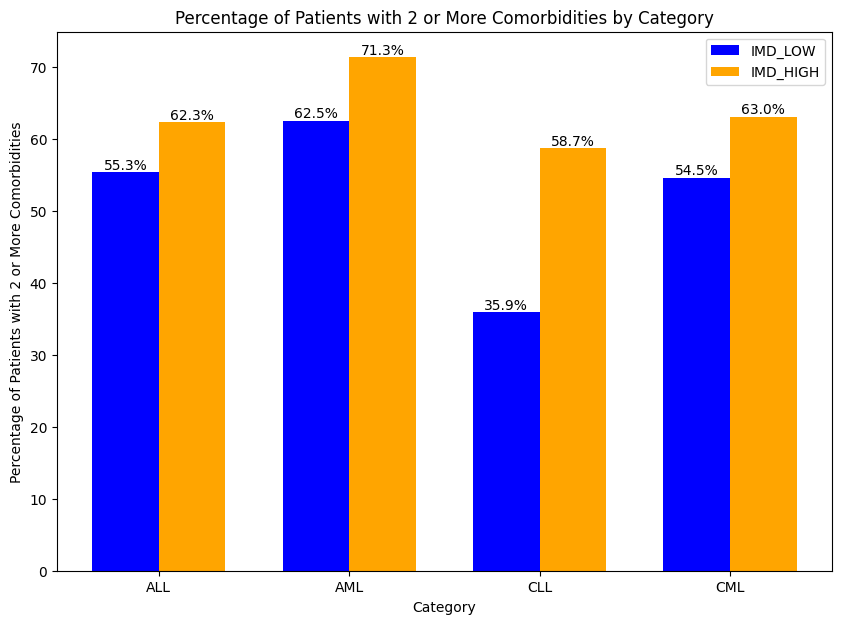

In [76]:
# Calculating the percentages for IMD_LOW
patients_with_comorbidities_low = charl_master_low[charl_master_low['comorbidity_count'] >= 2]
categories = ['ALL', 'AML', 'CLL', 'CML']
total_counts_low = {
    'ALL': charl_master_low['ALL'].sum(),
    'AML': charl_master_low['AML'].sum(),
    'CLL': charl_master_low['CLL'].sum(),
    'CML': charl_master_low['CML'].sum()
}
comorbidity_counts_low = {
    'ALL': patients_with_comorbidities_low['ALL'].sum(),
    'AML': patients_with_comorbidities_low['AML'].sum(),
    'CLL': patients_with_comorbidities_low['CLL'].sum(),
    'CML': patients_with_comorbidities_low['CML'].sum()
}
# Initializing an empty dictionary to store the percentages for the high group
percentages_low = {}

# Looping through each category to calculate the percentage
for category in categories:
    # Checking if the total count for the category is greater than 0 to avoid division by zero
    if total_counts_low[category] > 0:
        # Calculating the percentage and storing it in the dictionary
        percentage = (comorbidity_counts_low[category] / total_counts_low[category]) * 100
    else:
        # If total count is 0, set the percentage to 0
        percentage = 0
    
    # Assignin the calculated percentage to the corresponding category in the dictionary
    percentages_low[category] = percentage

# Calculating the percentages for IMD_HIGH
patients_with_comorbidities_high = charl_master_high[charl_master_high['comorbidity_count'] >= 2]
total_counts_high = {
    'ALL': charl_master_high['ALL'].sum(),
    'AML': charl_master_high['AML'].sum(),
    'CLL': charl_master_high['CLL'].sum(),
    'CML': charl_master_high['CML'].sum()
}
comorbidity_counts_high = {
    'ALL': patients_with_comorbidities_high['ALL'].sum(),
    'AML': patients_with_comorbidities_high['AML'].sum(),
    'CLL': patients_with_comorbidities_high['CLL'].sum(),
    'CML': patients_with_comorbidities_high['CML'].sum()
}
# Initializing an empty dictionary to store the percentages for the high group
percentages_high = {}

# Looping through each category to calculate the percentage
for category in categories:
    # Checking if the total count for the category is greater than 0 to avoid division by zero
    if total_counts_high[category] > 0:
        # Calculating the percentage and store it in the dictionary
        percentage = (comorbidity_counts_high[category] / total_counts_high[category]) * 100
    else:
        # If total count is 0, set the percentage to 0
        percentage = 0
    
    # Assigning the calculated percentage to the corresponding category in the dictionary
    percentages_high[category] = percentage

# Combining the results into a single DataFrame
percentages_df = pd.DataFrame({
    'Category': categories,
    'IMD_LOW': [percentages_low[category] for category in categories],
    'IMD_HIGH': [percentages_high[category] for category in categories]
})

# Plotting the double bar graph
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, percentages_df['IMD_LOW'], bar_width, label='IMD_LOW', color='blue')
bar2 = ax.bar([i + bar_width for i in index], percentages_df['IMD_HIGH'], bar_width, label='IMD_HIGH', color='orange')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Category')
ax.set_ylabel('Percentage of Patients with 2 or More Comorbidities')
ax.set_title('Percentage of Patients with 2 or More Comorbidities by Category')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

# Adding the percentage values on top of each bar
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.1f}%',
            ha='center',
            va='bottom'
        )

add_values_on_bars(bar1)
add_values_on_bars(bar2)

plt.show()


In [77]:
#Counting the number of patients true for each sub-type
count = 0
for index, row in charl_master_low.iterrows():
    if row['CLL'] == 1 and row['comorbidity_count'] >= 4:
        count += 1

print(count)

2


CREATING RADAR PLOTS TO VISUALISE THE PREVALENCE OF THE COMORBIDITIES CLUSTER-WISE AS WELL AS IMD CATEGORY-WISE.

In [78]:
# List of comorbidities
comorbidities = [
    'myocardial_infarction', 'congestive_heart_failure',
       'periphral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease',
       'connective_tissue_disease_rheumatic_disease', 'peptic_ulcer_disease',
       'mild_liver_disease', 'diabetes_wo_complications',
       'diabetes_w_complications', 'paraplegia_and_hemiplegia',
       'renal_disease', 'moderate_or_sever_liver_disease',
       'metastitic_carcinoma', 'aids_hiv'
]

# Creating a dictionary to store radar chart data for each cluster
radar_data = {}

# Looping through each cluster
for cluster in charl_master_subset['cluster'].unique():
    cluster_data = charl_master_subset[charl_master_subset['cluster'] == cluster][comorbidities].sum()  # Aggregating comorbidities for the cluster
    radar_data[cluster] = cluster_data.tolist()  # Convert to list


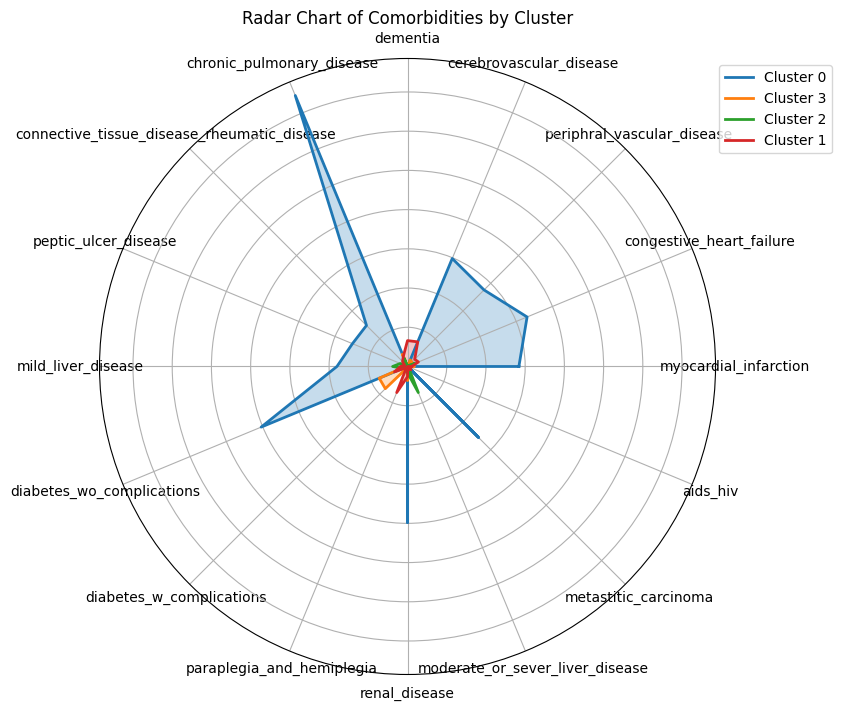

In [81]:
 # This function plots a radar chart given the data, labels for the axes, and a title.
def plot_radar_chart(data, labels, title):
    
   # Determine the number of variables (axes) based on the length of the labels list.
    num_vars = len(labels)
    
    # Computing the angle for each axis
    # Creating a list of angles for each axis on the radar chart. np.linspace generates evenly spaced values 
    # between 0 and 2π (a full circle), with a total number equal to the number of variables.
    # endpoint=False means that 2π itself is not included, ensuring the chart forms a loop.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
   
    # Appending the first angle to the end of the list to close the radar chart loop.
    angles += angles[:1]  
    
    # Creating a subplot with polar coordinates (necessary for radar charts).
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plotting each cluster
    # Looping through each cluster in the data dictionary. The key represents the cluster number,
    # and the value is a list of values corresponding to the axes.
    for cluster, values in data.items():
        values += values[:1]  
        # Plotting the data for this cluster on the radar chart. The line will connect the points at the given angles
        # with the corresponding values. The label is used in the legend, and linewidth controls the thickness of the line.
        ax.plot(angles, values, label=f'Cluster {cluster}', linewidth=2)

        # Filling the area under the line plot with a semi-transparent color (controlled by alpha).
        # This helps to visually distinguish the clusters.
        ax.fill(angles, values, alpha=0.25)
        

    # Customizing the radar chart
    # Remove the radial axis labels (which would otherwise display numbers like 1, 2, 3, etc. along the circles).
    ax.set_yticklabels([])
   
    # Setting the positions of the x-ticks (axis labels) at the appropriate angles, excluding the last angle since it repeats.
    ax.set_xticks(angles[:-1])

    # Labelling each axis with the corresponding label from the input list
    ax.set_xticklabels(labels)

    # Setting the title of the radar chart using the provided title.
    plt.title(title)

    # Adding a legend to the chart, placing it in the upper right corner of the plot. bbox_to_anchor helps position the legend outside the plot area.
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
   
    plt.show()

# Plotting radar charts
plot_radar_chart(radar_data, comorbidities, 'Radar Chart of Comorbidities by Cluster')

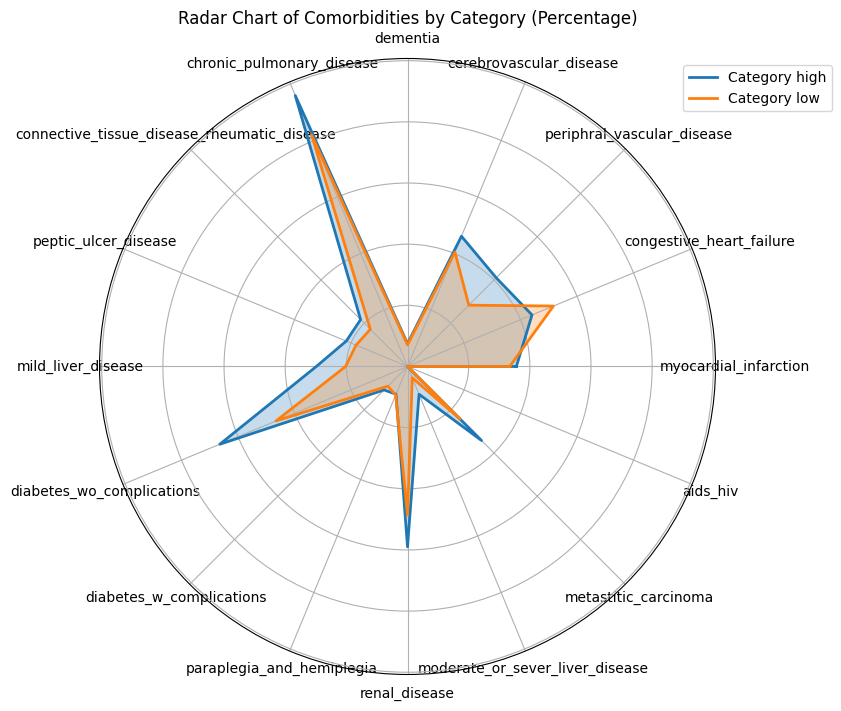

In [82]:
# Creating a dictionary to store radar chart data for each cluster
radar_data = {}

# Looping through each category
for category in charl_master_subset['category'].dropna().unique():
    category_data = charl_master_subset[charl_master_subset['category'] == category][comorbidities]
    category_sum = category_data.sum()
    category_count = category_data.notna().sum()
    category_percentage = (category_sum / category_count) * 100  # Calculate percentage
    radar_data[category] = category_percentage.tolist()  # Convert to list

def plot_radar_chart(data, labels, title):
    num_vars = len(labels)
    
    # Computing the angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plotting each category
    for category, values in data.items():
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, label=f'Category {category}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Customizing the radar chart
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.show()

# Plotting radar charts
plot_radar_chart(radar_data, comorbidities, 'Radar Chart of Comorbidities by Category (Percentage)')


Loading in the age_df data frame containing the age of onset of first occurrence disease classifications.

In [86]:
age_df= pd.read_csv('C:/Users/Aakanksha Choudhary/OneDrive/Desktop/project/age_df.csv', sep=',', header=0)

In [87]:
age_df.set_index('Unnamed: 0', inplace=True)
age_df.index.name = 'eid'


In [88]:
age_df

,infectious_parasitic,blood,endocrine_system,mental,nervous_system,eye,ear,circulatory_system,respiratory_system,digestive_system,skin,musculoskeletal_system,genitourinary_system,pregnancy,perinatal,congenital,age_at_cancer_diagnosis_f40008_0_0
eid,,,,,,,,,,,,,,,,,
1002912,999,999,52,999,999,999,999,50,999,55,54,54,999,999,999,44,55.2
1002951,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,53.5
1005217,999,999,999,999,999,999,999,999,999,999,999,53,999,999,999,999,56.7
1009538,999,999,999,999,999,999,999,52,999,52,999,999,999,999,999,999,55.0
1009715,46,999,999,53,999,46,999,999,999,58,58,999,50,999,999,999,58.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004309,999,999,50,999,999,999,999,999,999,51,999,999,999,999,999,999,63.2
6018053,999,72,999,999,999,999,72,999,65,55,60,62,41,999,999,999,72.2
6020766,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,999,41.5


In [89]:
#Merging the age of cancer diagnosis column with the carlson master table
charl_master_subset= charl_master_subset.merge(age_df[['age_at_cancer_diagnosis_f40008_0_0']], left_on= 'eid', right_index= True)

Calculating the mean age of onset for each leukaemia sub-type (AML, ALL, CLL and CML)

In [93]:
charl_high= charl_master_subset[charl_master_subset['category']== 'high']

In [94]:
charl_low= charl_master_subset[charl_master_subset['category']== 'low']

In [95]:
# Accessing the DataFrame for the key 'ALL'
df = charl_low[charl_master_subset['AML']== 1]
# Calculating the mean age at cancer diagnosis
mean_age_at_diagnosis = df['age_at_cancer_diagnosis_f40008_0_0'].mean()
print(mean_age_at_diagnosis)

60.721686746987956


C:\Users\Aakanksha Choudhary\AppData\Local\Temp\ipykernel_21048\3182245524.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = charl_low[charl_master_subset['AML']== 1]
